# 2.1.4. Bài tập thực hành 2: Xây dựng cây quyết định và rừng cây với dữ liệu Diabetes Prediction

**Mô tả bài toán:** Sử dụng dataset Diabetes Prediction để xây dựng mô hình phân loại dự đoán bệnh nhân có bị tiểu đường (diabetes = 1) hay không.

- **Features:** gender, age, hypertension, heart_disease, smoking_history, bmi, HbA1c_level, blood_glucose_level.
- **Target:** diabetes (0/1).

**Nhiệm vụ chính:**
1. Tiền xử lý dữ liệu (xử lý missing values, encode categorical features).
2. Xây dựng và đánh giá Decision Tree.
3. Xây dựng và đánh giá Random Forest.
4. Tối ưu hóa hyperparameters bằng GridSearchCV.
5. Visualize cây quyết định và feature importance.

**Lưu ý:** Dataset có thể lớn (~100k rows), sử dụng sample nếu cần để test nhanh. Giả sử file 'diabetes_prediction_dataset.csv' đã tải về thư mục làm việc.

In [1]:
# 1. Import các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400  # High res figures
import graphviz  # Để visualize decision trees (cài đặt: pip install graphviz)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import seaborn as sns  # Để EDA và visualize

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# 2. Load dữ liệu và xem cấu trúc
df = pd.read_csv('diabetes_prediction_dataset.csv')

print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nHead:\n", df.head())

# EDA ngắn gọn: Kiểm tra missing values và class distribution
print("\nMissing values:")
print(df.isnull().sum())
print("\nDiabetes distribution:")
print(df['diabetes'].value_counts(normalize=True))

Dataset shape: (100000, 9)

Columns: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']

Head:
    gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  

Missing values:
gender                 0
age                    0
hypertension           0
heart_disease        

In [3]:
# 3. Tiền xử lý dữ liệu
# Features: tất cả trừ target
features = ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level']
X = df[features].copy()
y = df['diabetes']

# Xử lý missing values (nếu có, nhưng dataset này clean)
# bmi có thể có NaN, impute median
imputer_bmi = SimpleImputer(strategy='median')
X['bmi'] = imputer_bmi.fit_transform(X[['bmi']])

# Encode categorical: gender (Male/Female), smoking_history (never/No Info/current/former/ever/not current)
le_gender = LabelEncoder()
X['gender'] = le_gender.fit_transform(X['gender'])

le_smoking = LabelEncoder()
X['smoking_history'] = le_smoking.fit_transform(X['smoking_history'])

# Split train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Preprocessing done.")
print("X_train shape:", X_train.shape)

Preprocessing done.
X_train shape: (80000, 8)


## Nhiệm vụ 1: Xây dựng và Visualize Decision Tree

In [4]:
# 4. Xây dựng Decision Tree cơ bản (max_depth=3 để visualize dễ)
dt = tree.DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, y_train)

# Predict trên test
y_pred_dt = dt.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)
auc_dt = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])
print(f"Decision Tree Accuracy: {acc_dt:.4f}")
print(f"Decision Tree AUC: {auc_dt:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.9723
Decision Tree AUC: 0.9059

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     18300
           1       1.00      0.67      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000



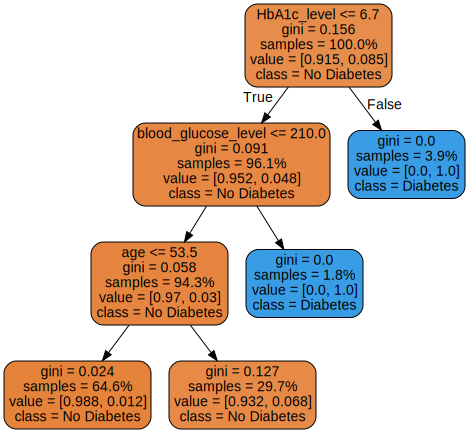

In [5]:
# 5. Visualize cây quyết định
feature_names = X_train.columns.tolist()
dot_data = tree.export_graphviz(dt,
                                out_file=None,
                                filled=True,
                                rounded=True,
                                feature_names=feature_names,
                                proportion=True,
                                class_names=['No Diabetes', 'Diabetes'])
graph = graphviz.Source(dot_data)
graph

## Nhiệm vụ 2: Tối ưu hóa Decision Tree bằng GridSearchCV

In [6]:
# 6. GridSearchCV cho max_depth (sử dụng roc_auc vì imbalanced)
params_dt = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 10]}
dt_grid = tree.DecisionTreeClassifier(random_state=42)
cv_dt = GridSearchCV(dt_grid, param_grid=params_dt, scoring='roc_auc',
                     cv=5, verbose=1, n_jobs=-1, return_train_score=True)
cv_dt.fit(X_train, y_train)

print("Best params for DT:", cv_dt.best_params_)
print("Best CV AUC:", cv_dt.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params for DT: {'max_depth': 10}
Best CV AUC: 0.973702868852459


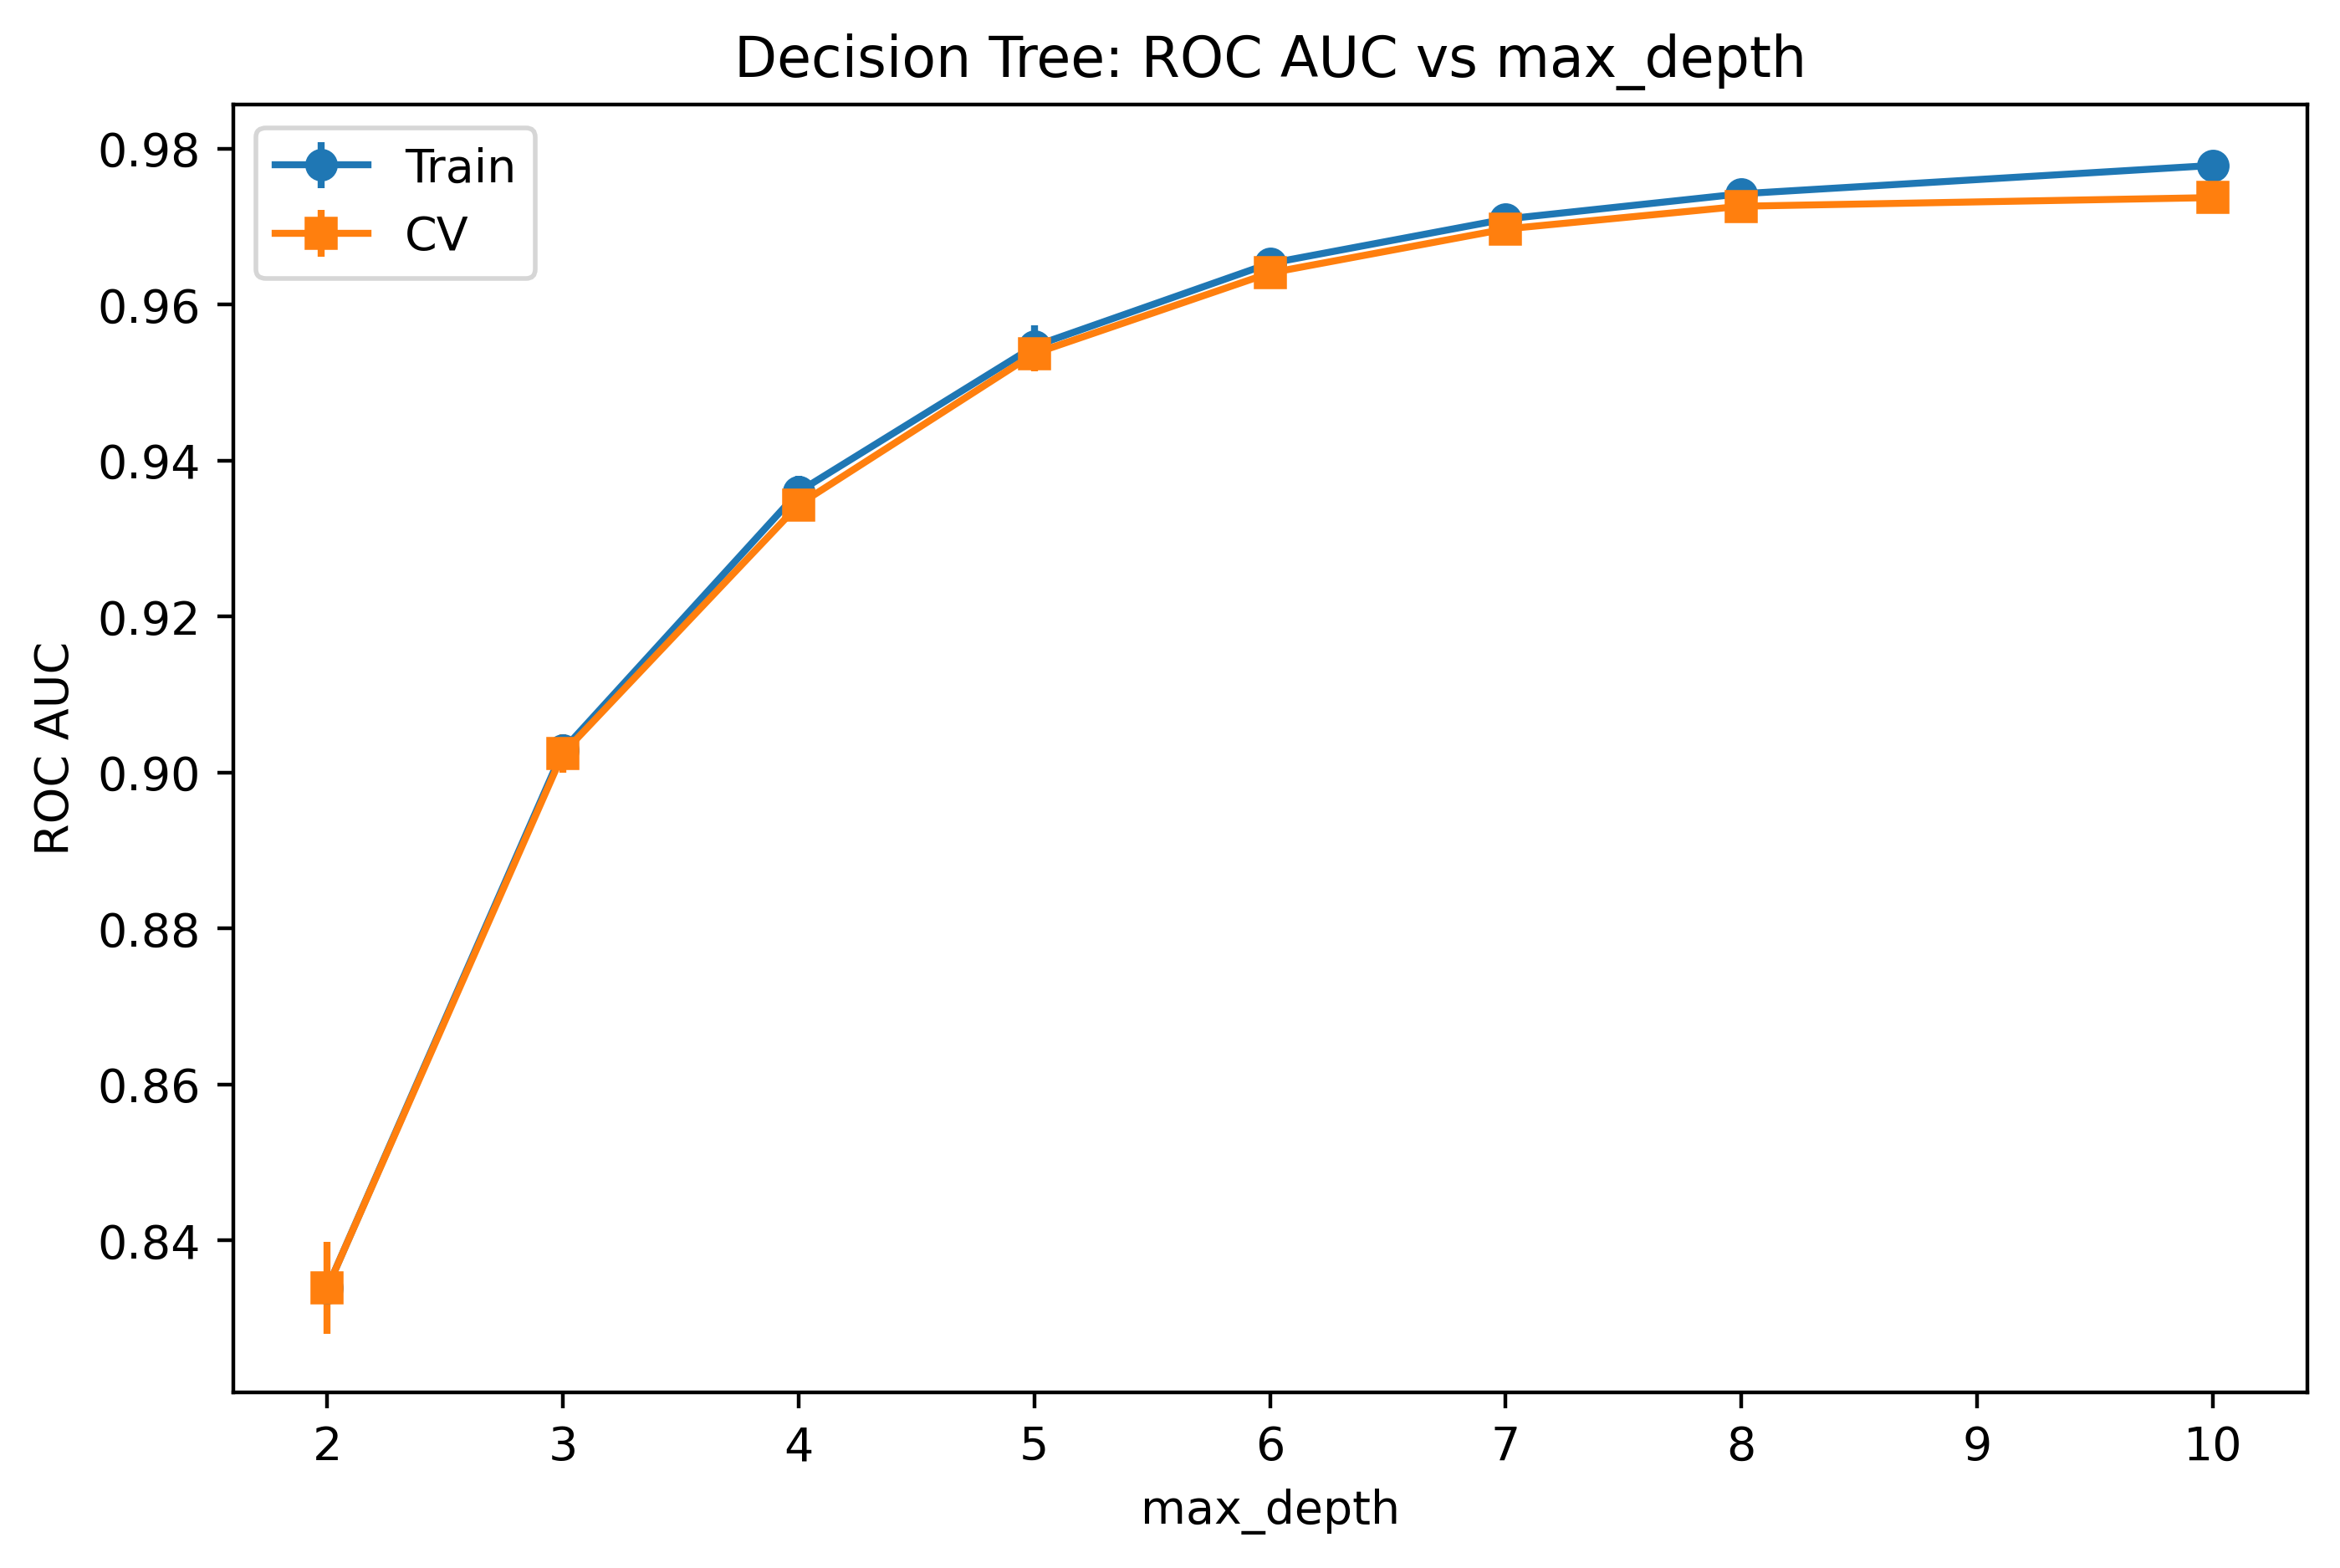

In [7]:
# 7. Vẽ biểu đồ đánh giá theo max_depth
cv_results_df = pd.DataFrame(cv_dt.cv_results_)
plt.figure(figsize=(8, 5))
plt.errorbar(cv_results_df['param_max_depth'],
             cv_results_df['mean_train_score'],
             yerr=cv_results_df['std_train_score'],
             label='Train', marker='o')
plt.errorbar(cv_results_df['param_max_depth'],
             cv_results_df['mean_test_score'],
             yerr=cv_results_df['std_test_score'],
             label='CV', marker='s')
plt.xlabel('max_depth')
plt.ylabel('ROC AUC')
plt.legend()
plt.title('Decision Tree: ROC AUC vs max_depth')
plt.show()

## Nhiệm vụ 3: Xây dựng và Tối ưu hóa Random Forest

In [8]:
# 8. Xây dựng Random Forest cơ bản
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predict và đánh giá
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
print(f"Random Forest Accuracy: {acc_rf:.4f}")
print(f"Random Forest AUC: {auc_rf:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.9723
Random Forest AUC: 0.9592

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     18300
           1       1.00      0.67      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000



In [9]:
# 9. GridSearchCV cho n_estimators (giới hạn để nhanh)
params_rf = {'n_estimators': [50, 100, 150, 200]}
rf_grid = RandomForestClassifier(max_depth=5, random_state=42, n_jobs=-1)
cv_rf = GridSearchCV(rf_grid, param_grid=params_rf, scoring='roc_auc',
                     cv=5, verbose=1, n_jobs=-1, return_train_score=True)
cv_rf.fit(X_train, y_train)

print("Best params for RF:", cv_rf.best_params_)
print("Best CV AUC:", cv_rf.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params for RF: {'n_estimators': 150}
Best CV AUC: 0.9593832971713276


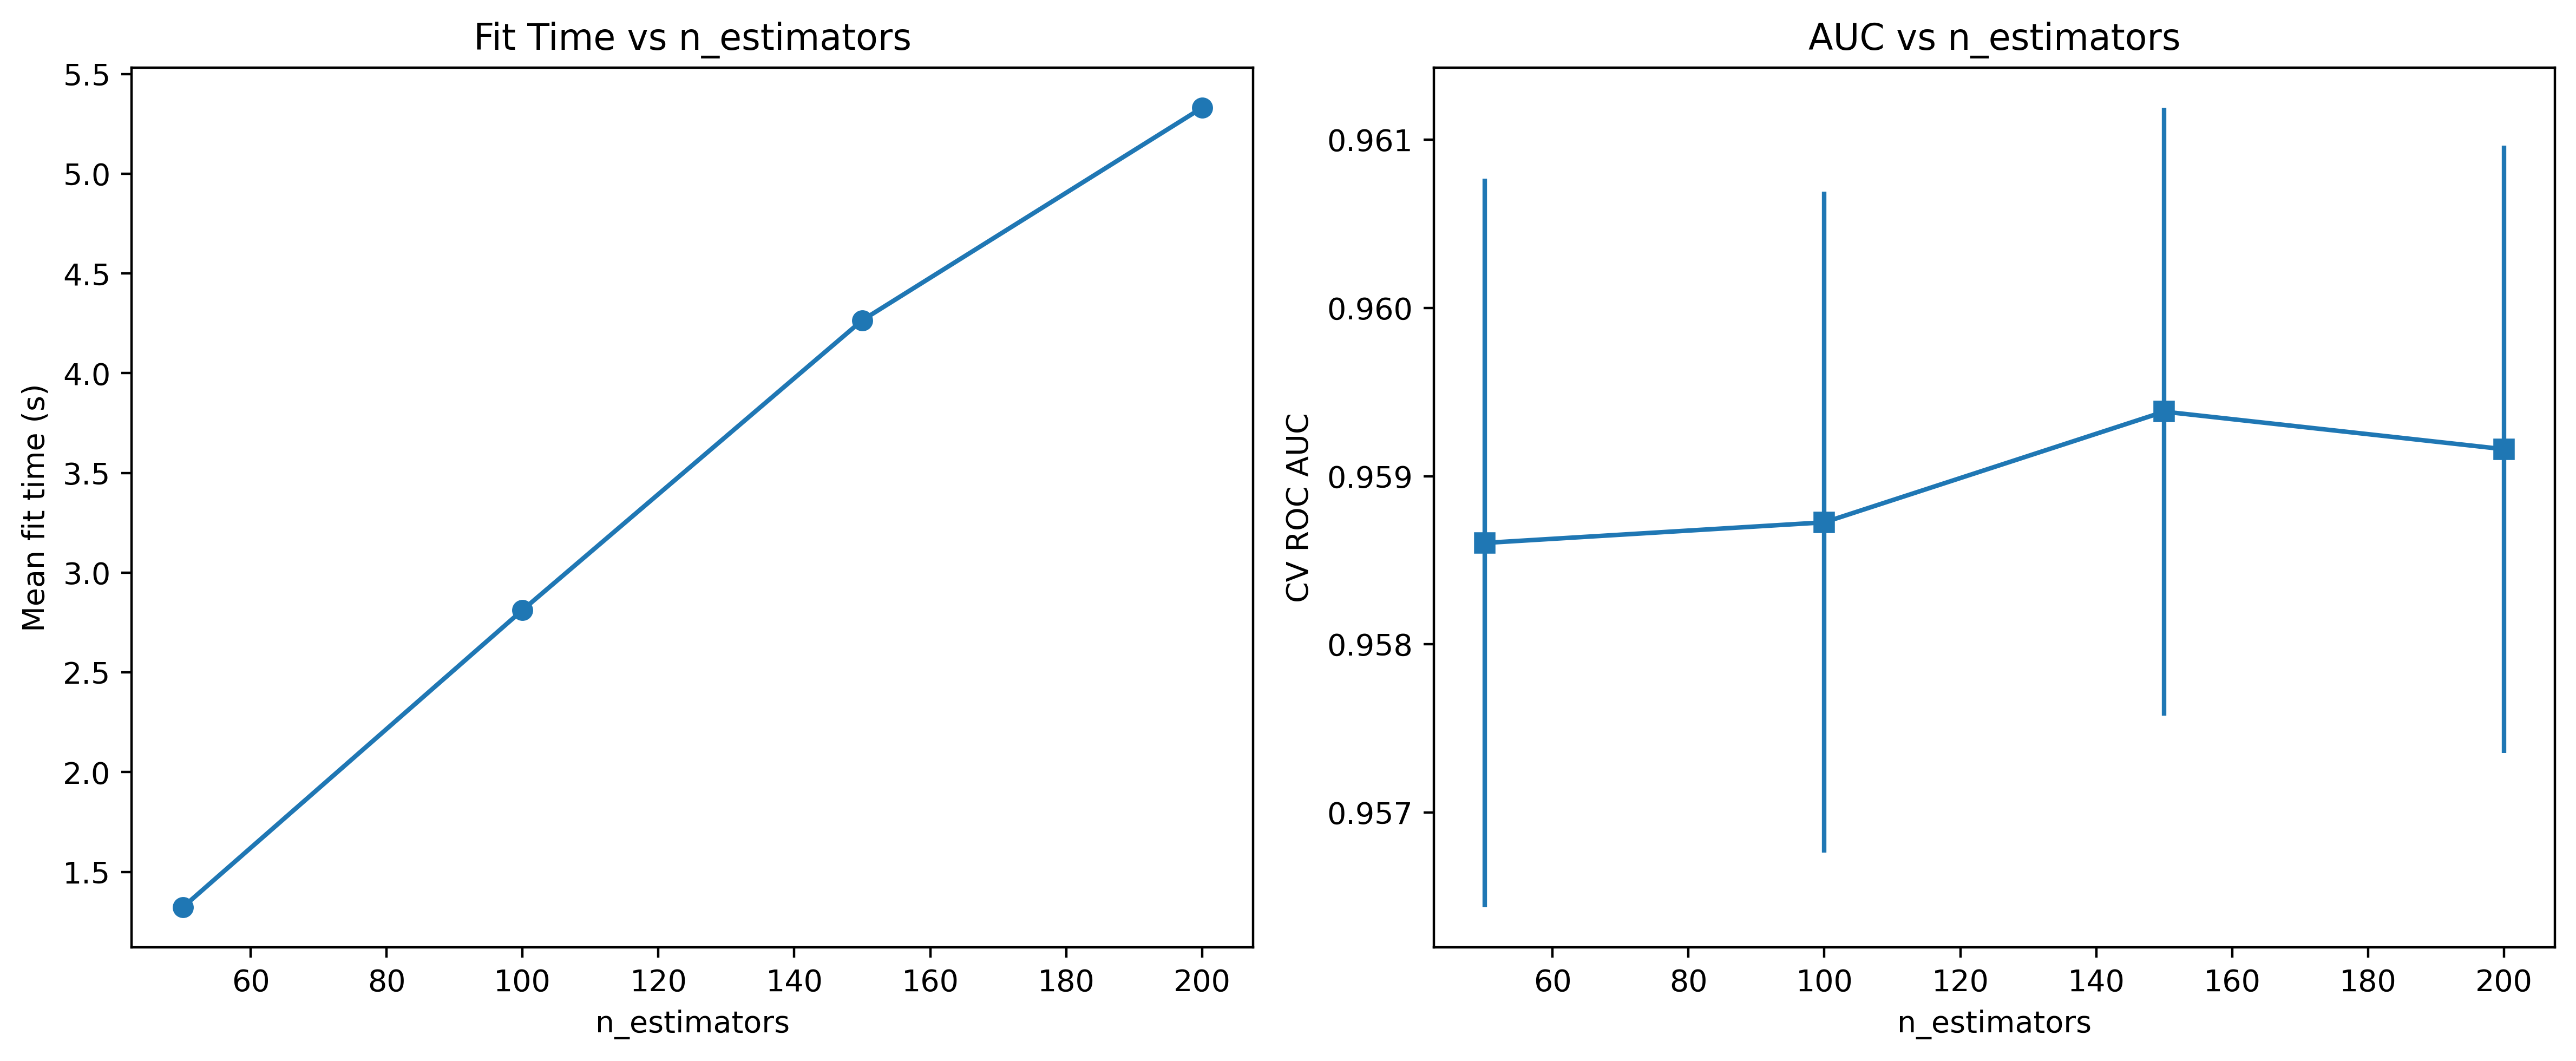

In [10]:
# 10. Vẽ biểu đồ đánh giá theo n_estimators
cv_rf_results_df = pd.DataFrame(cv_rf.cv_results_)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Fit time
ax1.plot(cv_rf_results_df['param_n_estimators'], cv_rf_results_df['mean_fit_time'], 'o-')
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('Mean fit time (s)')
ax1.set_title('Fit Time vs n_estimators')

# AUC
ax2.errorbar(cv_rf_results_df['param_n_estimators'],
             cv_rf_results_df['mean_test_score'],
             yerr=cv_rf_results_df['std_test_score'], marker='s')
ax2.set_xlabel('n_estimators')
ax2.set_ylabel('CV ROC AUC')
ax2.set_title('AUC vs n_estimators')

plt.tight_layout()
plt.show()

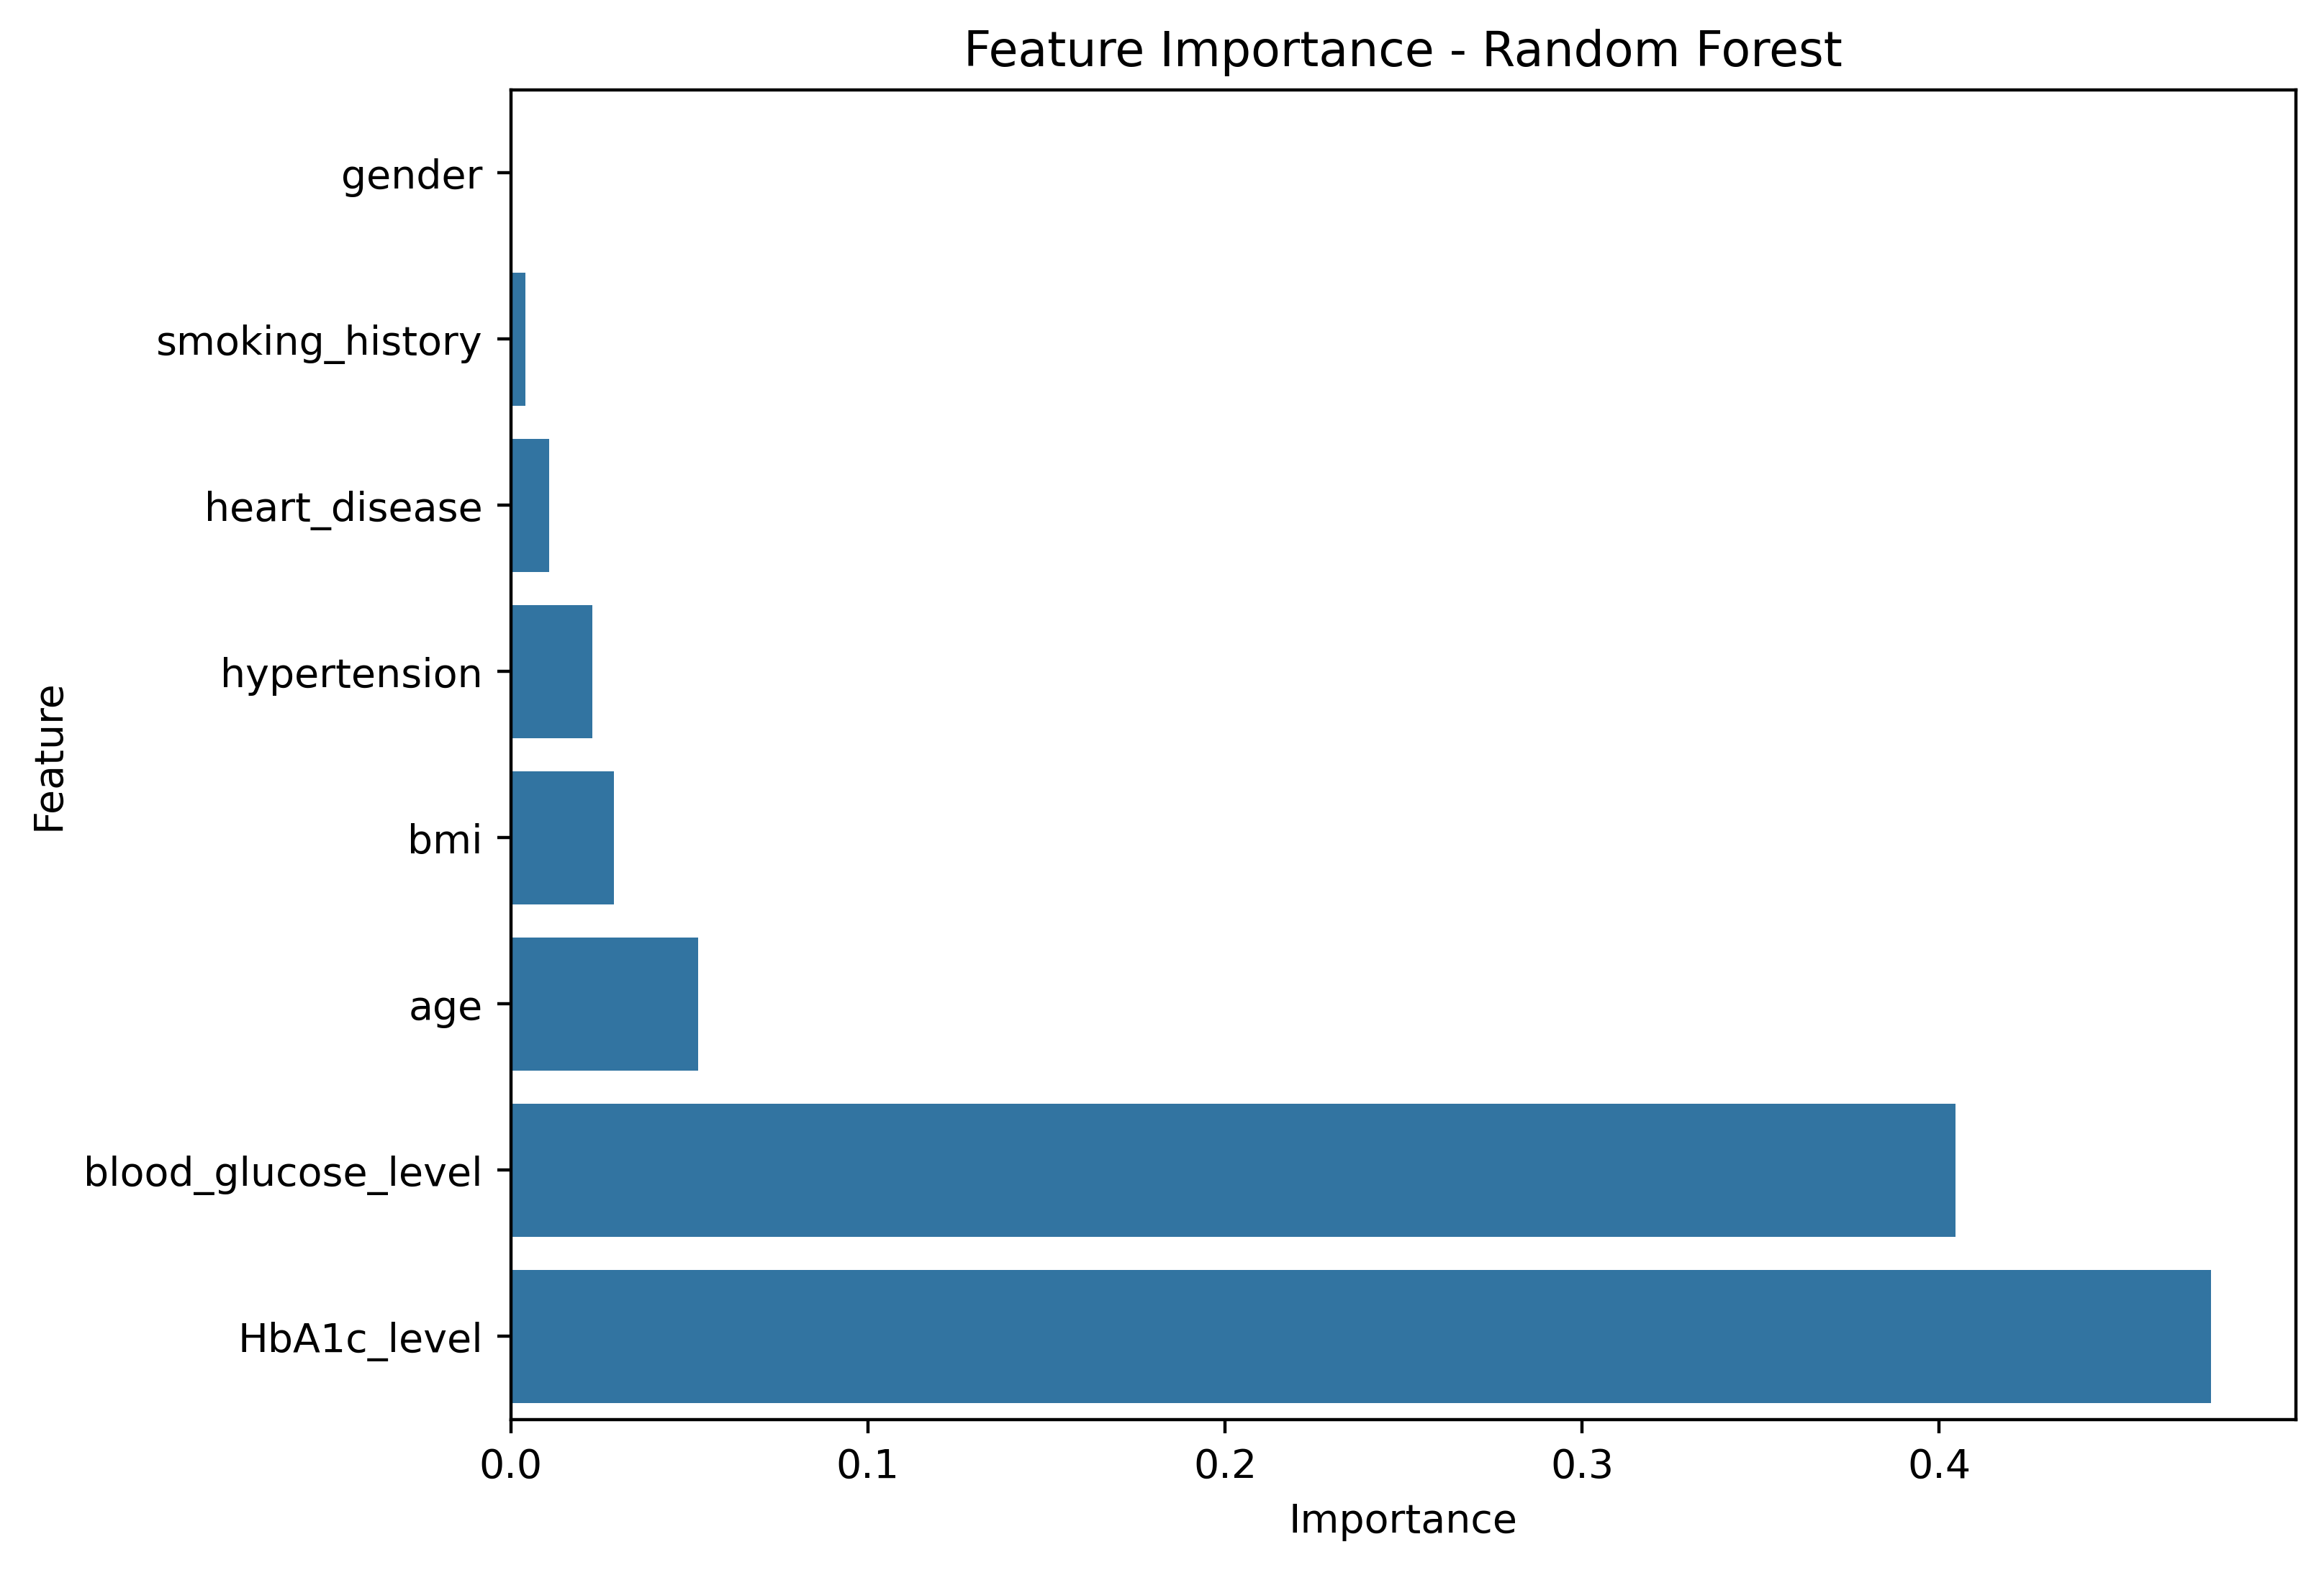

               Feature  Importance
0               gender    0.000413
4      smoking_history    0.003994
3        heart_disease    0.010720
2         hypertension    0.022901
5                  bmi    0.028802
1                  age    0.052486
7  blood_glucose_level    0.404626
6          HbA1c_level    0.476058


In [11]:
# 11. Feature Importance từ Random Forest tốt nhất
best_rf = cv_rf.best_estimator_
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=True)

plt.figure(figsize=(8, 6))
sns.barplot(data=feat_imp, x='Importance', y='Feature')
plt.title('Feature Importance - Random Forest')
plt.show()
print(feat_imp)